In [1]:
import time
import numpy as np
import pandas as pd
import sklearn.datasets 
from sklearn.decomposition import KernelPCA
from sklearn.manifold import TSNE
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from tqdm import tqdm

In [2]:
mnist = sklearn.datasets.fetch_openml('mnist_784')
X = mnist.data / 255.0
y = mnist.target
X, y = np.float32(X[:10000]), np.float32(y[:10000])
print(X.shape, y.shape)
feat_cols = [ 'pixel'+str(i) for i in range(X.shape[1]) ]
df = pd.DataFrame(X,columns=feat_cols)
df['y'] = np.float32(y)
df['label'] = df['y'].apply(lambda i: str(i))
# X, y = None, None
print('Size of the dataframe: {}'.format(df.shape))


np.random.seed(42)
rndperm = np.random.permutation(df.shape[0])

(10000, 784) (10000,)
Size of the dataframe: (10000, 786)


<Figure size 432x288 with 0 Axes>

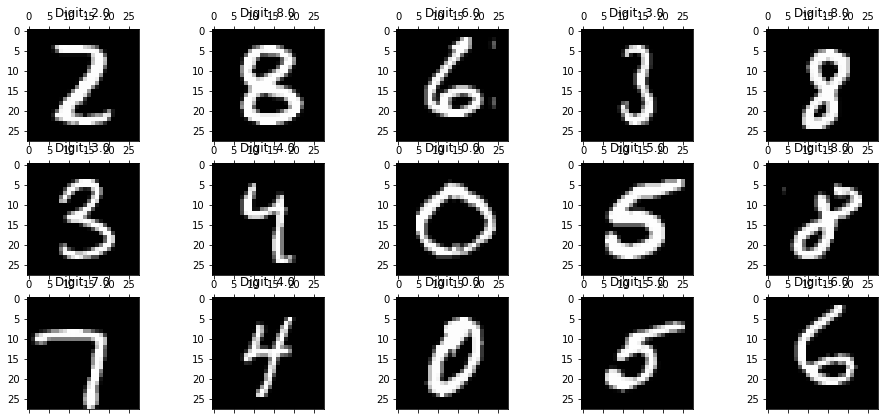

In [3]:
plt.gray()
fig = plt.figure( figsize=(16,7) )
for i in range(0,15):
    ax = fig.add_subplot(3,5,i+1, title="Digit: {}".format(str(df.loc[rndperm[i],'label'])) )
    ax.matshow(df.loc[rndperm[i],feat_cols].values.reshape((28,28)).astype(float))
plt.show()

Linear PCA

In [4]:
transformer = KernelPCA(n_components=2,kernel='linear')
x_trans = transformer.fit_transform(X)
x_trans.shape

/home/harsh/anaconda3/lib/python3.7/site-packages/sklearn/utils/extmath.py:530: RuntimeWarning: invalid value encountered in multiply
  v *= signs[:, np.newaxis]


(10000, 2)

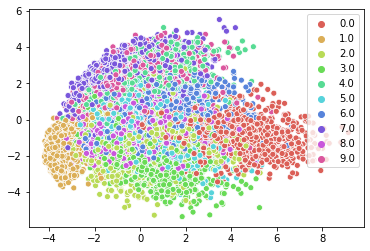

In [5]:
sns.scatterplot(x=x_trans[:,0],y=x_trans[:,1],hue=y,palette=sns.color_palette("hls", 10))

RBF PCA

(10000, 2)


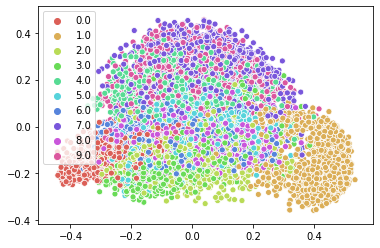

In [6]:
#Recommender Gamma

all_dists = np.linalg.norm(X-np.mean(X,axis=0),axis=1)
d_5,d_50,d_95 = np.percentile(all_dists, 5), np.percentile(all_dists, 50), np.percentile(all_dists, 95)
gamma_rec = -np.log(0.5)/(d_50**2)

transformer = KernelPCA(n_components=2,kernel='rbf',gamma=gamma_rec)
x_trans = transformer.fit_transform(X)
print(x_trans.shape)

sns.scatterplot(x=x_trans[:,0],y=x_trans[:,1],hue=y,palette=sns.color_palette("hls", 10))

(10000, 2)


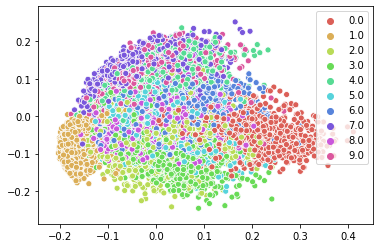

In [7]:
#Default Gamma

transformer = KernelPCA(n_components=2,kernel='rbf')
x_trans = transformer.fit_transform(X)
print(x_trans.shape)

sns.scatterplot(x=x_trans[:,0],y=x_trans[:,1],hue=y,palette=sns.color_palette("hls", 10))

p-RBF PCA

In [8]:
def p_gaussian_kernel(distances,p=10.0,sigma=1.0):
	kernel_vals = np.exp( - (distances/sigma)**p ) 
	return kernel_vals 

def get_p_kernel_matrix(x1,x2,k,p,sigma):
	df1 = lambda x: ((np.sum(abs(x)**k,axis=1))**(1/k) if len(x.shape)>1 else (np.sum(abs(x)**k))**(1/k))
	kernel_mat = np.zeros((len(x1),len(x2)))
	for i in tqdm(range(len(x1))):
# 		for j in range(i,len(x2)):
# 			kernel_mat[i,j]=np.exp(-(np.linalg.norm(x1[i]-x2[j])/sigma)**p)
# 			kernel_mat[j,i] = kernel_mat[i,j]
		kernel_mat[i,:] = np.exp( - ( np.array([np.linalg.norm(x1[i]-x2[j]) for j in range(len(x2))])/sigma)**p )
	return kernel_mat

In [9]:
k = 2.0	
df1 = lambda x: ((np.sum(abs(x)**k,axis=1))**(1/k) if len(x.shape)>1 else (np.sum(abs(x)**k))**(1/k))
all_dists = df1(X-np.mean(X,axis=0))
d_5, d_50, d_95 = np.percentile(all_dists,5),np.percentile(all_dists,50),np.percentile(all_dists,95)
p = np.log(np.log(0.05)/np.log(0.95)) / np.log(d_95/d_5) 
sigma = d_50/((-np.log(0.50))**(1/p))
kernel_train = get_p_kernel_matrix(X,X,k,p,sigma)

100%|██████████| 10000/10000 [21:34<00:00,  7.46it/s]


(10000, 2)


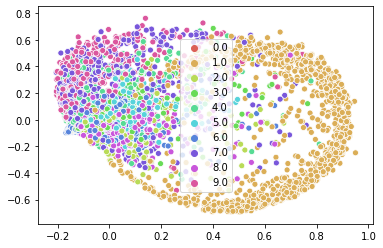

In [14]:
transformer = KernelPCA(n_components=2,kernel='precomputed')
transformer.fit(kernel_train)
x_trans = transformer.transform(kernel_train)
print(x_trans.shape)

sns.scatterplot(x=x_trans[:,0],y=x_trans[:,1],hue=y,palette=sns.color_palette("hls", 10))

f-p RBF

In [18]:
def fp_gaussian_kernel(distances,p=10.0,sigma=1.0):
	kernel_vals = np.exp( - (distances/sigma)**p ) 
	return kernel_vals 

def get_fp_kernel_matrix(x1,x2,k,p,sigma):
# 	df1 = lambda x: ((np.sum(abs(x)**k,axis=1))**(1/k) if len(x.shape)>1 else (np.sum(abs(x)**k))**(1/k))
	k=0.5
	kernel_mat = np.zeros((len(x1),len(x2)))
	for i in tqdm(range(len(x1))):
# 		for j in range(i,len(x2)):
# 			kernel_mat[i,j]=np.exp(-(np.linalg.norm(x1[i]-x2[j])/sigma)**p)
# 			kernel_mat[j,i] = kernel_mat[i,j]
		kernel_mat[i,:] = np.exp( - ( np.array([np.linalg.norm(x1[i]-x2[j],ord=k)**k for j in range(len(x2))])/sigma)**p )
	return kernel_mat

In [23]:
k = 0.5
df1 = lambda x: ((np.sum(abs(x)**k,axis=1)) if len(x.shape)>1 else (np.sum(abs(x)**k)))
all_dists = df1(X-np.mean(X,axis=0))
d_5, d_50, d_95 = np.percentile(all_dists,5),np.percentile(all_dists,50),np.percentile(all_dists,95)
p = np.log(np.log(0.05)/np.log(0.95)) / np.log(d_95/d_5) 
sigma = d_50/((-np.log(0.50))**(1/p))
kernel_train = get_fp_kernel_matrix(X,X,k,p,sigma)

100%|██████████| 10000/10000 [36:07<00:00,  4.62it/s]


(10000, 2)


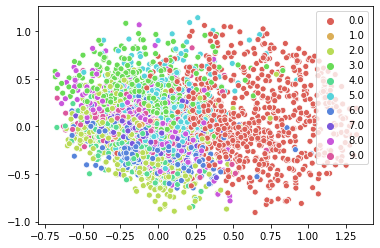

In [24]:
transformer = KernelPCA(n_components=2,kernel='precomputed')
transformer.fit(kernel_train)
x_trans = transformer.transform(kernel_train)
print(x_trans.shape)

sns.scatterplot(x=x_trans[:,0],y=x_trans[:,1],hue=y,palette=sns.color_palette("hls", 10))

In [25]:
kernel_train

array([[1.        , 0.99954604, 0.97707868, ..., 0.99992303, 0.99955545,
        0.99986134],
       [0.99954604, 1.        , 0.90247844, ..., 0.98207033, 0.99204055,
        0.99957278],
       [0.97707868, 0.90247844, 1.        , ..., 0.98664709, 0.99959645,
        0.99807885],
       ...,
       [0.99992303, 0.98207033, 0.98664709, ..., 1.        , 0.99970439,
        0.9999613 ],
       [0.99955545, 0.99204055, 0.99959645, ..., 0.99970439, 1.        ,
        0.99998537],
       [0.99986134, 0.99957278, 0.99807885, ..., 0.9999613 , 0.99998537,
        1.        ]])